In [1]:
# %%
# Imports and Settings
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
import torch
import scanpy as sc
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import seaborn
import PyComplexHeatmap as pch
import scvi
import gseapy
import glasbey
from colorspacious import cspace_convert
import anndata
import re

# antipode & utils
import antipode
from antipode.antipode_model import ANTIPODE
from antipode.model_functions import (
    get_real_leaf_means, numpy_hardmax, group_aggr_anndata
)
from antipode.train_utils import *
from antipode.plotting import get_prerank_from_mat
from genomics import sc_analysis  # from your mts‑utils

# %%
# Device & Figure Defaults
sc.settings.figdir = os.path.expanduser('~/WbFigures/DevFinalAnalysis')
sc._settings.settings._vector_friendly = True

plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.family': 'DejaVu Sans',
    'font.sans-serif': 'DejaVuSansMono',
    'pdf.fonttype': 42
})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
if device.type == 'cuda':
    print("GPU count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on cpu


In [2]:
batch_key='batch_name'
discov_key='species'
layer_key='spliced'
leaf_key='Initial_Class_markers_level_2'
MDE_KEY = "X_antipode_UMAP"
anndata.settings.allow_write_nullable_strings = True

model_tag   = '1.9.1.8.5_Dev_final_600clusters'
model_path='/home/matthew.schmitz/Matthew/models/'+model_tag
adata = sc.read_h5ad(os.path.join(model_path,'analysis_inprogress.h5ad'))
model=antipode.antipode_model.ANTIPODE.load(model_path,adata=adata,prefix='p3_',device=device)
model.save_params_to_uns()
adata=model.adata_manager.adata
pstore = adata.uns['param_store']
adata.var = pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/gene_lists/var.csv',index_col=0)

INFO     Generating sequential column names                                                                        


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  s

In [3]:
pstore = adata.uns['param_store']
discov_cluster_params,cluster_params, cluster_labels,var_labels, zero_mask,(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)=model.calculate_cluster_params(flavor='numpy')
keep_clusters = np.array([x in adata.obs['level_2'].unique() for x in cluster_labels ])
cluster_labels = np.array(cluster_labels)[keep_clusters]
zero_mask = zero_mask[:,keep_clusters,:]
cluster_index = np.array([int(x) for x in cluster_labels])
zero_mask = np.nan_to_num(zero_mask,posinf=np.nan)
discov_cluster_params = discov_cluster_params[:,cluster_index,:] * zero_mask
prop_locs = prop_locs[cluster_index,:]
prop_discov_di = prop_discov_di[:,cluster_index,:] * zero_mask
prop_discov_dm = prop_discov_dm[:,cluster_index,:] * zero_mask
discov_labels=adata.obs[model.discov_key].cat.categories
latent_labels=[str(x) for x in range(pstore['discov_dc'].shape[1])]
n_clusters=model.level_sizes[-1]


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:451: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [4]:
zdw_df = pd.DataFrame(pstore['z_decoder_weight'],columns = var_labels).T

In [5]:
leaf_key = 'Initial_Class_markers_level_2'

In [6]:
row_linkage = adata.uns[f'dendrogram_{leaf_key}']['linkage']
cluster_order = adata.uns[f'dendrogram_{leaf_key}']['categories_ordered']
inv_order = np.argsort(adata.uns[f'dendrogram_{leaf_key}']['categories_idx_ordered'])

In [7]:
adata.uns['level_2_colors_dict'] = dict(zip([int(x) for x in adata.uns['level_2_colors_dict'].keys()],adata.uns['level_2_colors_dict'].values()))
adata.uns['level_1_colors_dict'] = dict(zip([int(x) for x in adata.uns['level_1_colors_dict'].keys()],adata.uns['level_1_colors_dict'].values()))
leaf_l2_dict = dict(zip(adata.obs['Initial_Class_markers_level_2'].cat.categories,adata.obs['level_2'].cat.categories))
l2_leaf_dict = dict(zip(adata.obs['level_2'].cat.categories,adata.obs['Initial_Class_markers_level_2'].cat.categories))


In [8]:
pstore = adata.uns['param_store']
(
    discov_cp, cp, labels, var_labels, zm,
    (pt,_, di, dm)
) = model.calculate_cluster_params(flavor='numpy')

# keep only present clusters
keep = np.isin(labels, adata.obs['level_2'].cat.categories.astype(int))
labels = np.array(labels)[keep]
zm     = zm[:,keep,:]
idx    = labels.astype(int)

# apply mask
discov_cp = np.nan_to_num(discov_cp[:,idx,:],posinf=np.nan)*zm
pt        = pt[idx,:]
di        = di[:,idx,:]*zm
dm        = dm[:,idx,:]*zm

prop_locs_dynam = np.einsum('pc,cm->pm', 
                           pt, 
                           pstore['locs_dynam'])

prop_locs = np.einsum('pc,cm->pm', 
                           pt, 
                           pstore['locs'])

# take log of the sum of absolute values per cluster
dynam_var = np.log(np.abs(prop_locs_dynam).sum(axis=1))

# map back to each cell’s level_2 label
dynam_dict = {i: dynam_var[i] for i in range(len(dynam_var))}
adata.obs['log_abs_sum_dynam'] = (
    adata.obs[leaf_key]
        .map(dynam_dict)
)

cluster_idx    = labels

# 2) make string labels for each latent dimension
latent_labels  = [str(i) for i in range(pstore['locs'].shape[1])]

# 3) DataFrame of propagated locations
loc_df = pd.DataFrame(
    prop_locs,
    index=[l2_leaf_dict[x] for x in cluster_idx],
    columns=latent_labels
)

# 4) “Raw” locs (before propagation)
leaf_loc_df = pd.DataFrame(
    pstore['locs'][cluster_idx, :],
    index=cluster_idx,
    columns=latent_labels
)

# 5) add tiny noise for numerical stability
loc_df += np.random.standard_normal(loc_df.shape) * 1e-10

# 6) set the index name so dendrogram code picks it up
loc_df.index.name      = leaf_key
leaf_loc_df.index.name = leaf_key


/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:450: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  zero_mask = (adata.obs.groupby(self.discov_key)[leaf_level].value_counts().unstack().loc[:,cluster_labels]>=cluster_count_threshold).to_numpy()
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:451: RuntimeWarning: divide by zero encountered in divide
  return discov_cluster_params,cluster_params, cluster_labels,var_labels, 1/zero_mask[...,np.newaxis],(prop_taxon, prop_locs,prop_discov_di,prop_discov_dm)


In [9]:
# row_linkage = scipy.cluster.hierarchy.linkage(loc_df, method='average')
# cluster_order = scipy.cluster.hierarchy.leaves_list(row_linkage)

for lvl in ['Neighborhood','Division','Initial_Class','Initial_Class_markers','level_1','level_2']:
    print(lvl)
    cols = [adata.uns[f"{lvl}_colors_dict"][x] for x in adata.obs[lvl].cat.categories]
    cmap = matplotlib.colors.ListedColormap(cols,name=f"{lvl}_pal")
    try:    matplotlib.colormaps.unregister(name=f"{lvl}_pal",cmap=cmap)
    except: pass
    try:    matplotlib.colormaps.register(name=f"{lvl}_pal",cmap=cmap)
    except: pass

cluster_labels = cluster_order
discov_labels = adata.obs[discov_key].cat.categories
dc_df=pd.DataFrame(pstore['discov_dc'].var(2).T,index=latent_labels,columns=discov_labels)
prop_di=np.einsum('lc,scg->slg',pt,pstore['discov_di'])
prop_dm=np.einsum('lc,scg->slg',pt,pstore['discov_dm'])
dm_df=pd.DataFrame(prop_dm.var(2).T,index=cluster_labels,columns=discov_labels)
dmt_df=pd.DataFrame((prop_dm.var(1)).T,index=latent_labels,columns=discov_labels)
di_df=pd.DataFrame(prop_di.var(2).T,index=cluster_labels,columns=discov_labels)
adata.obs[leaf_key] = adata.obs[leaf_key].cat.reorder_categories(adata.obs[leaf_key].cat.categories)

Neighborhood
Division
Initial_Class
Initial_Class_markers
level_1
level_2


In [10]:
cell_cutoff=50

cluster_anno_df=pd.DataFrame(adata.obs.groupby(leaf_key)['level_1'].value_counts(dropna=True).unstack().idxmax(1))
cluster_anno_df.columns=['level_1']
cluster_anno_df[leaf_key]=adata.obs[leaf_key].cat.categories
adata.obs['n_genes'] = (adata.layers[layer_key]>0).sum(1).A1
cluster_anno_df['log_n_genes']=np.log10(adata.obs.groupby(leaf_key)['n_genes'].mean())
cluster_anno_df['phase']=adata.obs.groupby(leaf_key)['phase'].value_counts(dropna=True).unstack().idxmax(1)
cluster_anno_df['Initial_Class']=adata.obs.groupby(leaf_key)['Initial_Class'].value_counts(dropna=True).unstack().idxmax(1)
cluster_anno_df['Division']=adata.obs.groupby(leaf_key)['Division'].value_counts(dropna=True).unstack().idxmax(1)
cluster_anno_df['Division']=cluster_anno_df['Division'].astype('category')
cluster_anno_df['Division']=cluster_anno_df['Division'].cat.reorder_categories(adata.obs['Division'].cat.categories)
cluster_anno_df['level_1']=cluster_anno_df['level_1'].astype(str)

cluster_anno_df['Initial_Class']=cluster_anno_df['Initial_Class'].astype('category')
cluster_anno_df['Initial_Class']=cluster_anno_df['Initial_Class'].cat.reorder_categories(adata.obs['Initial_Class'].cat.categories)

species_binary=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()>cell_cutoff
zdw_mat=pd.DataFrame(np.absolute(pstore['z_decoder_weight']),index=latent_labels,columns=var_labels).T
species_mat=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()
species_mat=(species_mat/species_mat.sum(0))
region_mat=adata.obs.groupby(leaf_key)['general_region'].value_counts(normalize=True).unstack()
region_mat=region_mat.loc[:,['ctx','ge','bn','de','mb','hb','cp','h']]


cluster_anno_df.index=list(cluster_anno_df[leaf_key])
species_ha_dict={}
for col in region_mat.columns:
    species_ha_dict[col]=pch.anno_simple(region_mat[col],cmap='Oranges',legend=False)

for col in species_mat.columns:
    species_ha_dict[col+' cell#']=pch.anno_simple(species_mat[col],cmap='Blues',legend=False)

for col in species_binary.columns:
    species_ha_dict[col+'>'+str(cell_cutoff)]=pch.anno_simple(1-species_binary[col].astype(float),cmap='Grays',legend=False)

for col in di_df.columns:
    species_ha_dict[col+'_DI']=pch.anno_simple(di_df[col],cmap='Reds',legend=False)

for col in dm_df.columns:
    species_ha_dict[col+'_DM']=pch.anno_simple(dm_df[col],cmap='Purples',legend=False)


# species_ha_dict['label']=pch.anno_label(cluster_anno_df[leaf_key], merge=True, rotation=0,adjust_color=False,colors='black',extend=False,relpos=[20.,0.],fontsize=1.2,arrowprops = dict(visible=False))


left_ha = pch.HeatmapAnnotation(
            Division=pch.anno_simple(cluster_anno_df.Division,colors=[adata.uns['Division_colors_dict'][x] for x in cluster_anno_df.Division.unique()], rasterized=False,legend=True),#,cmap='Division_pal'),
            Initial_Class=pch.anno_simple(cluster_anno_df.Initial_Class, rasterized=False,legend=False,colors=[adata.uns['Initial_Class_colors_dict'][x] for x in cluster_anno_df.Initial_Class.unique()]),
            level_1=pch.anno_simple(cluster_anno_df.level_1, rasterized=False,legend=False,colors=[adata.uns['level_1_colors_dict'][int(x)] for x in cluster_anno_df.level_1.unique()]),
            phase=pch.anno_simple(cluster_anno_df['phase'], rasterized=False,colors=[adata.uns['phase_color_dict'][x] for x in cluster_anno_df.phase.unique()],legend=True),#
            log10_n_genes=pch.anno_simple(cluster_anno_df.log_n_genes, rasterized=False,legend=False,cmap='Blues'),**species_ha_dict,
            axis=0)

/scratch/fast/1601709/ipykernel_3142085/3147187884.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_anno_df=pd.DataFrame(adata.obs.groupby(leaf_key)['level_1'].value_counts(dropna=True).unstack().idxmax(1))
/scratch/fast/1601709/ipykernel_3142085/3147187884.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_anno_df['log_n_genes']=np.log10(adata.obs.groupby(leaf_key)['n_genes'].mean())
/scratch/fast/1601709/ipykernel_3142085/3147187884.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

In [11]:
cell_cutoff=50
# species_binary=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()>cell_cutoff
# zdw_mat=pd.DataFrame(np.absolute(pstore['z_decoder_weight']),index=latent_labels,columns=var_labels).T
# species_mat=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()
# species_mat=(species_mat/species_mat.sum(0))
# region_mat=adata.obs.groupby(leaf_key)['general_region'].value_counts(normalize=True).unstack()
# region_mat=region_mat.loc[:,['ctx','ge','bn','de','mb','hb','cp','h']]

species_ha_dict={}
# for col in region_mat.columns:
#     species_ha_dict[col]=pch.anno_simple(region_mat[col],cmap='Greens',legend=False)

# for col in species_mat.columns:
#     species_ha_dict[col+' cell#']=pch.anno_simple(species_mat[col],cmap='Blues',legend=False)

# for col in species_binary.columns:
#     species_ha_dict[col+'>'+str(cell_cutoff)]=pch.anno_simple(species_binary[col],cmap='Grays',legend=False)

# for col in dm_df.columns:
#     species_ha_dict[col+'_DM']=pch.anno_simple(dm_df[col],cmap='Purples',legend=False)

# for col in di_df.columns:
#     species_ha_dict[col+'_DI']=pch.anno_simple(di_df[col],cmap='Reds',legend=False)

# species_ha_dict['label']=pch.anno_label(cluster_anno_df[leaf_key], merge=True, rotation=0,adjust_color=False,colors='black',extend=False,relpos=[-100.,0.],fontsize=1.2,arrowprops = dict(visible=False))

# right_ha = pch.HeatmapAnnotation(**species_ha_dict,axis=0)


In [17]:
div_markers={'G0':list(set([])),#'YWHAG','NNAT'
             'G1':list(set(['CCND1','CCND2','CCND3','CCNE1','CCNE2','MKI67','PCNA'])),
'G1S':list(set(['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7',
      'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'RAD51AP1', 'GMNN', 
      'WDR76', 'SLBP', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 
      'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 
      'E2F8','H4C3','H1-3','H1-5','H2AC12','H2AC20','H1-2','H1-4','H1-1','FBXO5',
      'SPC25','FAM83D','HIST1H1A','HIST1H1B','HIST1H1C','HIST1H1D','HIST1H1E','CCND1','CCND2','CCND3'])),#,'CCNE1', 'CCNE2'
'G2M':list(set(['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 
       'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 
       'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 
       'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 
       'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 
       'GAS2L3', 'CBX5','ASPM','CENPA','CCND1','CCND2','CCND3']))
        }

gl_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/gene_lists/'
vg_genes=pd.read_csv(os.path.join(gl_path,'HGNC_voltage_gated.tsv'),sep='\t')
np_genes=pd.read_csv(os.path.join(gl_path,'MTS_neuropeptides_receptors.tsv'),sep='\t')
np_genes['type'] = np_genes['type'].str.split(',')
np_genes = np_genes.explode('type')
autism_genes=pd.read_csv(os.path.join(gl_path,'SFARI_autism.tsv'),sep='\t')
tf_genes=pd.read_csv(os.path.join(gl_path,'TFs_lambert_pmid29425488_1.01.txt'),sep='\t')

short_gene_lists={
    'G1/S':div_markers['G1S'],
    'G2/M':div_markers['G2M'],
    'TFs':tf_genes['hgnc_symbol'],
    'SFARI Autism':autism_genes.loc[autism_genes['gene-score']>2,'gene-symbol']
}

bp_dict=gseapy.get_library('GO_Biological_Process_2025')
bp_keys=list(bp_dict.keys())

chosen_bp=['Heterochromatin Formation (GO:0031507)',
'Mitochondrion Distribution (GO:0048311)',
 ]
bp=chosen_bp

for x in bp:
    term=x.split(' (GO:')[0]
    short_gene_lists[term]=bp_dict[x]

for k in short_gene_lists.keys():
    if adata.var.index.isin(short_gene_lists[k]).sum()<5:
        try:
            del gene_lists[k]
        except:
            pass


gene_lists={
    'G1/S':div_markers['G1S'],
    'G2/M':div_markers['G2M'],
    #'Voltage-gated':vg_genes['Approved symbol'],
    #'TFs':tf_genes['hgnc_symbol'],
    'SFARI Autism':autism_genes.loc[autism_genes['gene-score']>1,'gene-symbol'],
}




for k in short_gene_lists.keys():
    if adata.var.index.isin(short_gene_lists[k]).sum()<5:
        try:
            del gene_lists[k]
        except:
            pass


In [18]:
zdw_mat

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
TRAPPC2,0.008458,7.496192e-03,7.085626e-03,4.990943e-03,6.039295e-03,1.036575e-03,0.011566,3.094331e-03,7.484631e-04,0.000601,...,0.013549,6.906696e-03,1.927175e-03,2.462062e-05,1.134552e-02,0.022477,0.026386,2.275703e-02,2.851529e-02,0.019690
C17orf49,0.054829,2.871161e-02,4.721964e-04,7.553502e-03,1.697515e-02,2.083846e-01,0.010870,1.876858e-03,1.007641e-02,0.005970,...,0.089933,1.528449e-02,3.542217e-02,6.910822e-02,1.653748e-02,0.001570,0.020008,3.886824e-02,1.859915e-02,0.001125
C2orf68,0.003915,1.400851e-02,2.088931e-03,9.307734e-04,7.484578e-03,3.857739e-03,0.001825,2.754479e-02,8.565007e-03,0.005928,...,0.019646,5.174673e-03,3.253828e-03,7.504475e-02,1.671216e-02,0.002668,0.062532,1.518568e-03,1.187763e-02,0.000255
C4orf19,0.055777,9.090021e-04,2.549571e-02,5.819614e-02,1.061063e-02,1.693694e-01,0.004332,4.467733e-02,8.291923e-04,0.090955,...,0.046191,2.011544e-02,2.232683e-01,1.254302e-02,5.750138e-02,0.000066,0.000722,6.641201e-04,3.597628e-01,0.000021
C4orf54,0.006099,1.188782e-07,1.454145e-07,1.159097e-07,1.602534e-08,1.254381e-05,0.117894,6.779592e-08,1.984275e-08,0.071543,...,0.001215,7.212737e-07,1.502269e-01,3.641519e-08,1.043365e-08,0.000003,0.000002,7.318058e-07,1.072504e-07,0.000158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,0.004776,1.510518e-02,7.768237e-03,3.736123e-03,1.965811e-02,1.461937e-02,0.010029,6.736245e-04,2.823654e-03,0.003817,...,0.004752,5.438599e-03,4.340721e-04,1.843891e-02,1.409572e-02,0.018067,0.032165,1.444124e-02,1.593596e-02,0.012748
ZYX,0.051893,2.097780e-02,1.377698e-02,3.864555e-03,2.858233e-02,5.948391e-02,0.002312,1.930980e-03,2.492275e-02,0.000022,...,0.005261,9.462879e-04,2.135731e-02,9.835535e-03,9.989832e-03,0.003203,0.027416,2.651606e-02,1.543900e-01,0.004152
ZZEF1,0.007379,3.588849e-04,1.905479e-03,2.567437e-02,2.714402e-03,6.344246e-03,0.003776,9.232886e-04,4.278527e-03,0.000345,...,0.009970,2.870454e-03,5.774237e-03,3.041337e-02,7.000038e-03,0.003553,0.037359,4.874342e-02,2.444849e-03,0.002012
ASIP,0.000002,4.442194e-05,1.909573e-05,8.262242e-06,5.623194e-07,3.518851e-04,0.000130,2.018601e-03,5.819249e-03,0.000012,...,0.000019,8.188792e-02,1.802154e-07,3.682858e-02,8.234133e-06,0.000127,0.054942,8.044576e-07,3.290351e-07,0.000247


In [19]:
prerank_out=antipode.plotting.get_prerank_from_mat(zdw_mat,short_gene_lists,min_size=3,max_size=max([len(short_gene_lists[k]) for k in short_gene_lists.keys()])+100,permutation_num=1000)
prerank_out_df=prerank_out.pivot_table( index='input_column',columns='Term', values='NES', aggfunc='first').astype(float)
prerank_out_pval_df=prerank_out.pivot_table( index='input_column',columns='Term', values='FDR q-val', aggfunc='first').astype(float)

  0%|          | 1/200 [00:02<08:16,  2.49s/it]2025-07-06 23:55:44,186 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  1%|          | 2/200 [00:04<06:41,  2.03s/it]2025-07-06 23:55:45,882 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  2%|▏         | 4/200 [00:07<05:46,  1.77s/it]2025-07-06 23:55:49,172 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  3%|▎         | 6/200 [00:10<05:30,  1.70s/it]2025-07-06 23:55:52,497 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  4%|▍         | 8/200 [00:14<05:22,  1.68s/it]2025-07-06 23:55:55,815 [WARNING] Duplicated values found in prer

In [20]:
term_linkage=scipy.cluster.hierarchy.linkage(prerank_out_df.T,method='average',metric='correlation')
term_linkage_order_inds=scipy.cluster.hierarchy.leaves_list(term_linkage)
term_linkage_order=pd.Series(prerank_out_df.columns)[scipy.cluster.hierarchy.leaves_list(term_linkage)].to_list()

#cluster columns by abscorr
R = loc_df.corr(method='kendall').values#np.corrcoef(loc_df.T)        
# R = np.corrcoef(loc_df.T)            
D = 1 - np.abs(R)
col_linkage = scipy.cluster.hierarchy.linkage(D[np.triu_indices_from(D,1)], method="average")
latent_label_order_inds = scipy.cluster.hierarchy.leaves_list(col_linkage)
latent_label_order=pd.Series(latent_labels)[latent_label_order_inds].to_list()

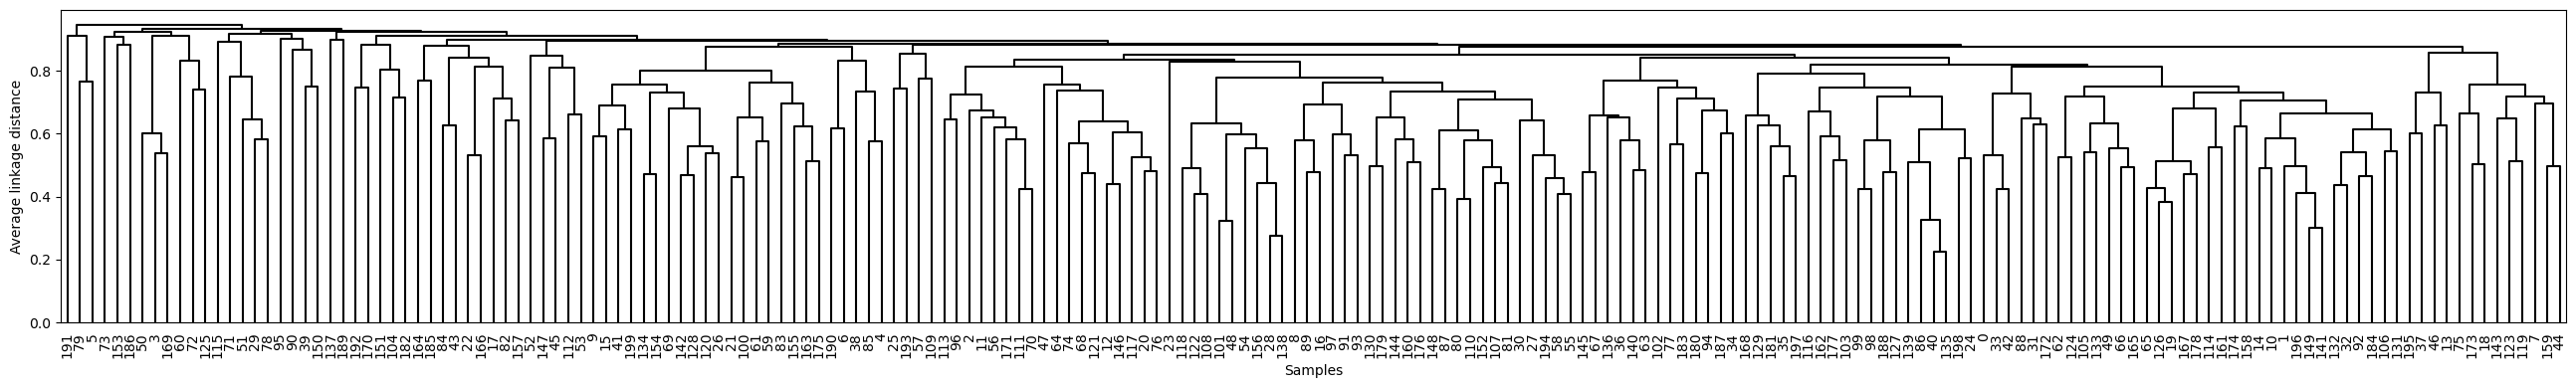

In [21]:
plt.figure(figsize=(26, 4))
scipy.cluster.hierarchy.dendrogram(
    col_linkage,
    labels=latent_label_order,
    leaf_rotation=90,      # rotate labels for readability
    leaf_font_size=10,     # adjust if labels overlap
    above_threshold_color='black',
    color_threshold=0   # draw all in same color; remove if you want automatic coloring
)
plt.xlabel("Samples")
plt.ylabel("Average linkage distance")
plt.tight_layout()
# plt.savefig(os.path.join(sc.settings.figdir,'module_dendrogram.svg'))
plt.show()


In [22]:
fit_xs_scores = pd.read_csv('/home/matthew.schmitz/WbFigures/RegionalClocks/fit_xs_scores_scores.tsv',sep='\t',index_col=0)
fit_dt_scores = pd.read_csv('/home/matthew.schmitz/WbFigures/RegionalClocks/fit_dt_scores_scores.tsv',sep='\t',index_col=0)
fit_com_scores = pd.read_csv('/home/matthew.schmitz/WbFigures/RegionalClocks/fit_mu_scores_scores.tsv',sep='\t',index_col=0)

xs_corrs = []
for i in zdw_df.columns:
    xs_corrs.append(scipy.stats.spearmanr(zdw_df.loc[fit_xs_scores.index,i],fit_xs_scores).statistic)
xs_corrs = pd.Series(xs_corrs,index = zdw_df.columns.astype(str))

com_corrs = []
for i in zdw_df.columns:
    com_corrs.append(scipy.stats.spearmanr(zdw_df.loc[fit_com_scores.index,i],fit_com_scores).statistic)
com_corrs = pd.Series(com_corrs,index = zdw_df.columns.astype(str))

dt_corrs = []
for i in zdw_df.columns:
    dt_corrs.append(scipy.stats.spearmanr(zdw_df.loc[fit_dt_scores.index,i],fit_dt_scores).statistic)
dt_corrs = pd.Series(dt_corrs,index = zdw_df.columns.astype(str))


In [25]:
column_df.loc[column_df.index,k]

56     1.309035
113    1.014502
173    1.109672
147    0.843332
80     0.979139
         ...   
81     1.040547
182    0.979316
63     1.002269
52     1.008455
55     0.932788
Name: SFARI Autism, Length: 200, dtype: float64

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


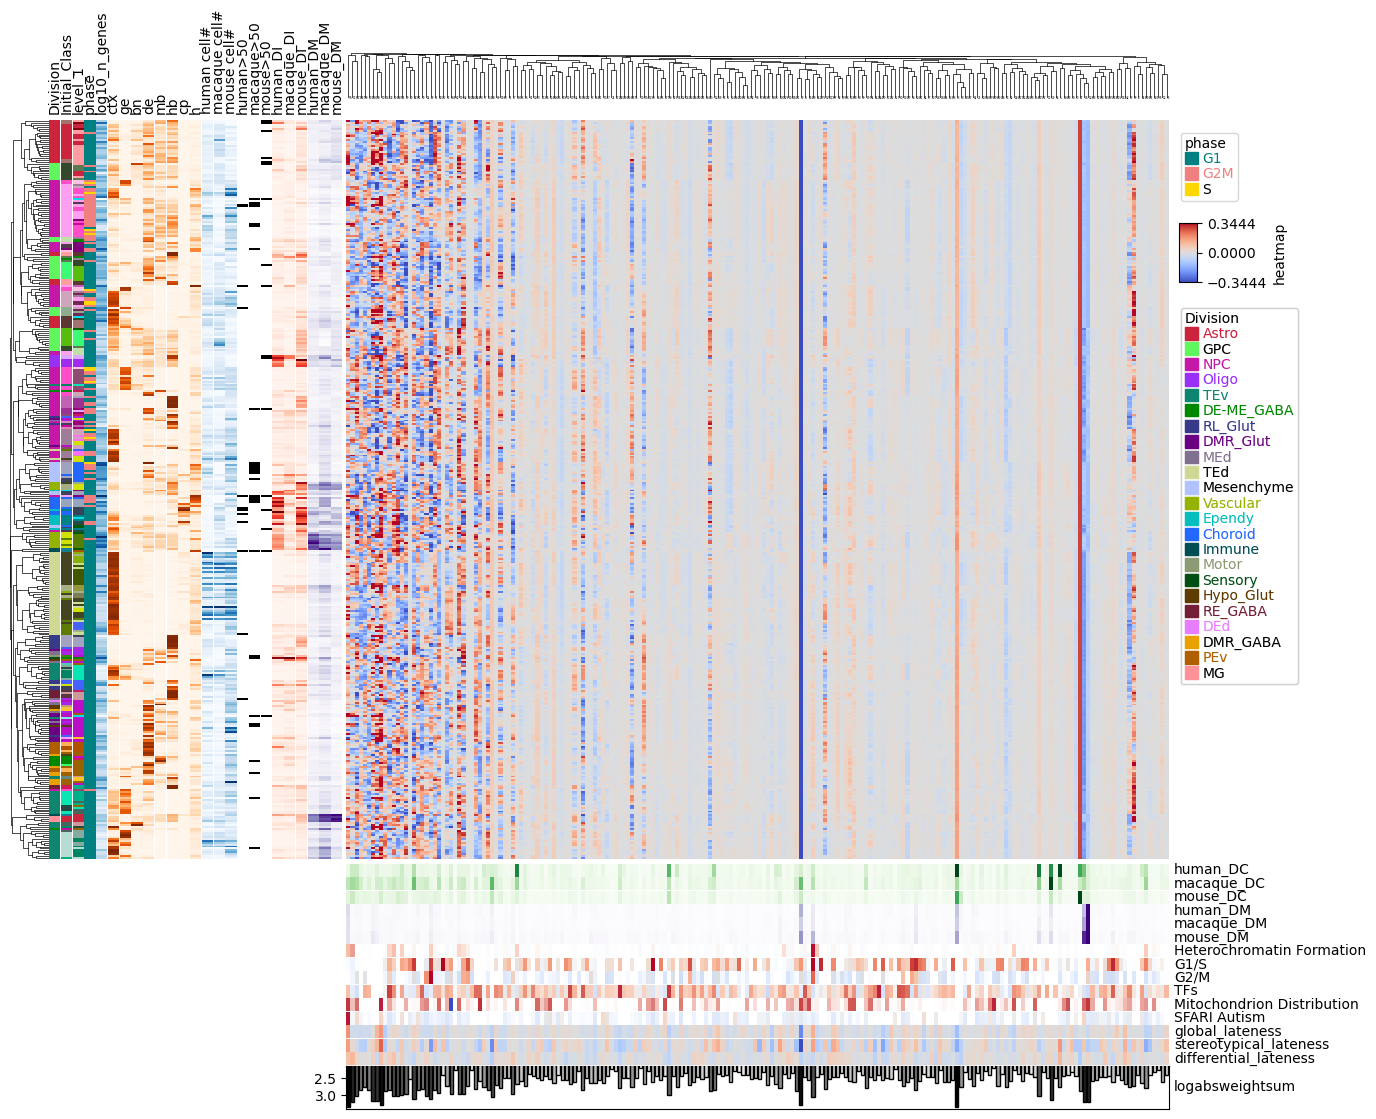

In [27]:
latent_ha_dict={}
breaks=pd.DataFrame({'breaks':[str(int(np.floor(i/20))) for i in range(len(latent_label_order))]},index=latent_label_order)

column_df=dc_df.copy()
column_df.loc[:,prerank_out_df.columns]=prerank_out_df
column_df.loc[:,breaks.columns]=breaks
column_df['index']=column_df.index
column_df=column_df.loc[latent_label_order,:]
column_df['xs_corrs'] = xs_corrs
column_df['com_corrs'] = com_corrs
column_df['dt_corrs'] = dt_corrs

for col in dc_df.columns:
    latent_ha_dict[col+'_DC']=pch.anno_simple(column_df[col],cmap='Greens',legend=False,rasterized=True)

for col in dmt_df.columns:
    latent_ha_dict[col+'_DM']=pch.anno_simple(dmt_df[col],cmap='Purples',legend=False,rasterized=True)

for k in term_linkage_order:#gl_preranks.keys():
    latent_ha_dict[k]=pch.anno_simple(column_df[k],cmap='coolwarm',legend=False,alpha=(1-prerank_out_pval_df.loc[column_df.index,k]))#vmin=prerank_out_df[k].min(),vmax=column_df[k].max(),

latent_ha_dict['global_lateness']=pch.anno_simple(column_df['xs_corrs'],cmap='coolwarm',legend=False,center=0.,vmin=-0.5,vmax=0.5)
latent_ha_dict['stereotypical_lateness']=pch.anno_simple(column_df['com_corrs'],cmap='coolwarm',legend=False,center=0.,vmin=-0.5,vmax=0.5)
latent_ha_dict['differential_lateness']=pch.anno_simple(column_df['dt_corrs'],cmap='coolwarm',legend=False,center=0.,vmin=-0.5,vmax=0.5)

#latent_ha_dict['breaks']=pch.anno_simple(column_df['breaks'])

mat_anno_df=pd.DataFrame(np.log10(1.+np.absolute(pstore['z_decoder_weight']).sum(1)),columns=['logabsweightsum'],index=latent_labels)
column_df['logabsweightsum']=mat_anno_df
latent_ha_dict['logabsweightsum']=pch.anno_barplot(mat_anno_df['logabsweightsum'], cmap='Greys',rasterized=True,legend=False)
bottom_ha = pch.HeatmapAnnotation(**latent_ha_dict,axis=1,orientation='down',plot=False)


top_anno_dict={}
top_anno_dict['label']=pch.anno_label(column_df['index'], merge=True, rotation=0,adjust_color=False,colors='black',extend=True,relpos=[0.,-6.],fontsize=2,arrowprops = dict(visible=False))
top_anno = pch.HeatmapAnnotation(**top_anno_dict,axis=1,orientation='up',plot=False)


plt.figure(figsize=(15,12))
scaleddf = loc_df.loc[cluster_order].iloc[inv_order]
# scaleddf=((loc_df-loc_df.mean(0))/(np.quantile(loc_df.std(0),0.25)+loc_df.std(0)))
max_val=np.max(np.absolute(scaleddf.min(),scaleddf.max()))*0.5 #clip to 0.5 of max to make more visible
cm1 = pch.ClusterMapPlotter(data=scaleddf,cmap='coolwarm',row_cluster=True,row_dendrogram=True,row_dendrogram_kws={'linkage':row_linkage},left_annotation=left_ha,top_annotation=top_anno,bottom_annotation=bottom_ha,col_cluster=True,col_dendrogram=True,col_dendrogram_kws={'linkage':col_linkage},rasterized=True,vmin=-max_val,vmax=max_val) #,right_annotation=right_ha
plt.savefig(os.path.join(sc.settings.figdir,'Fig2Clustermap.svg'))
plt.show()

100%|██████████| 98/98 [03:38<00:00,  2.23s/it]


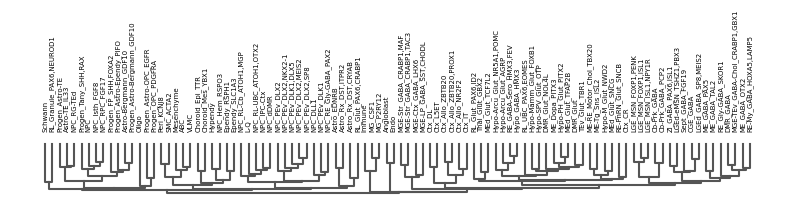

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 25.930555555555557 mm


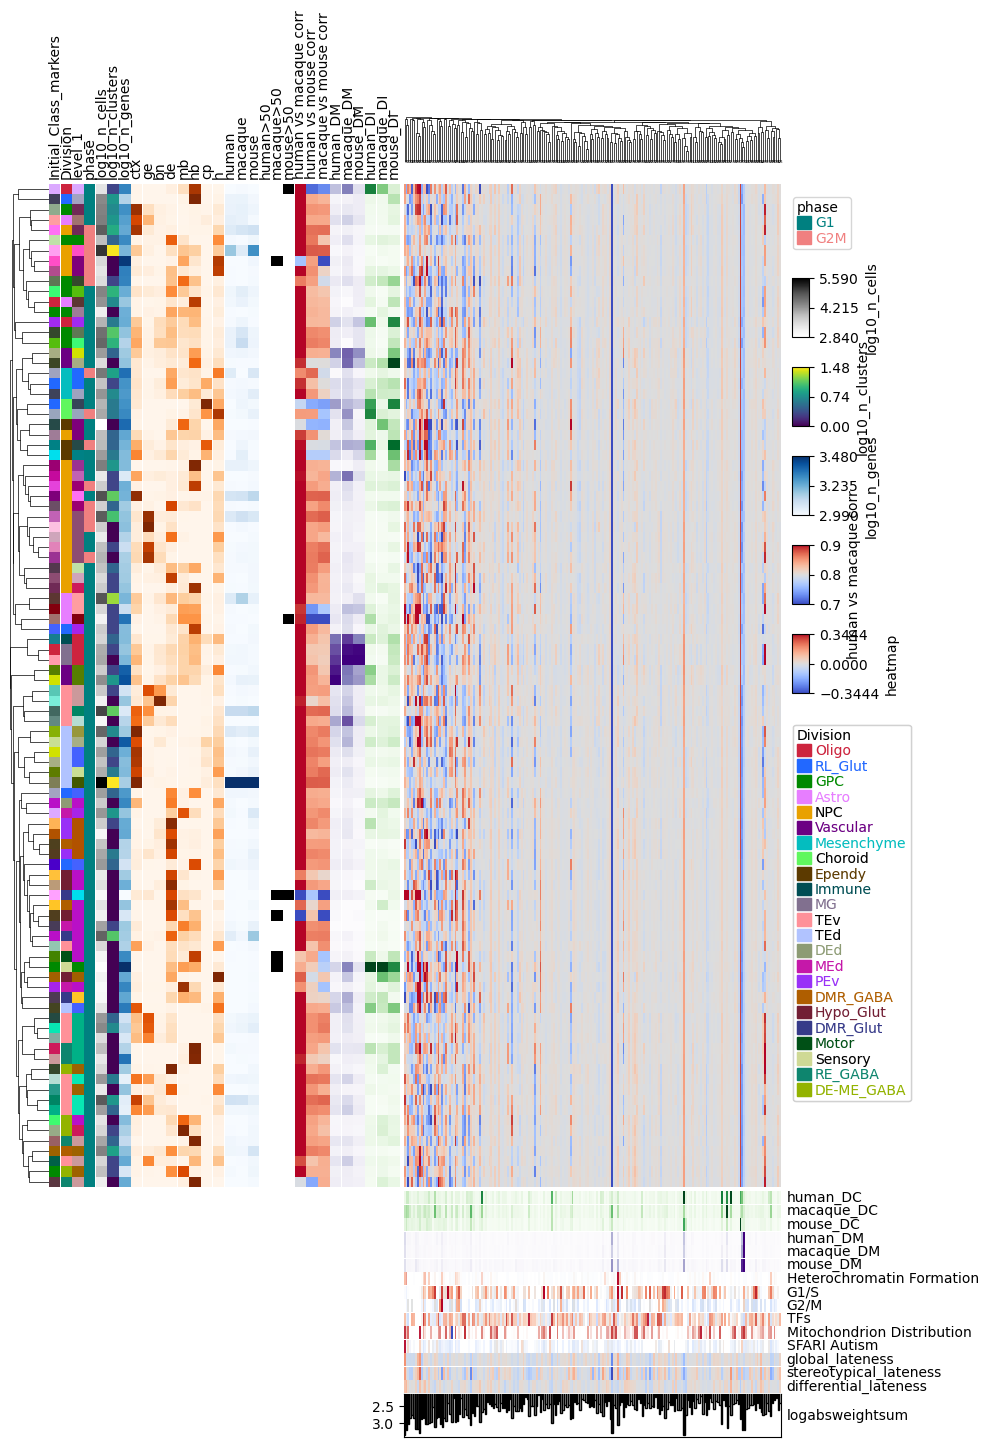

In [28]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy

# 1) choose the new leaf
leaf_key = 'Initial_Class_markers'
adata.obs[leaf_key] = adata.obs[leaf_key].astype('category')

##Calculate corrs for later
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import itertools
import xarray as xr

Initial_Class_log_real_means,Initial_Class_real_mean_levels=antipode.model_functions.get_real_leaf_means(adata,discov_key,leaf_key,layer=layer_key)
iclrm = xr.DataArray(Initial_Class_log_real_means,dims=[discov_key,leaf_key,'var'],coords={discov_key:Initial_Class_real_mean_levels[discov_key],leaf_key:Initial_Class_real_mean_levels[leaf_key],'var':adata.var.index})


# 2) recompute the dendrogram on Initial_Class_markers
sc.tl.dendrogram(
    adata,
    groupby=leaf_key,
    use_rep='X_antipode',
    linkage_method='average',
    cor_method='kendall'
)
# reorder categories so all downstream code “sees” the new order
adata.obs[leaf_key] = adata.obs[leaf_key].cat.reorder_categories(
    adata.uns[f'dendrogram_{leaf_key}']['categories_ordered']
)

# 3) plot it
with plt.rc_context({'font.size': 6}):
    fig, ax = plt.subplots(figsize=(10, 0.7))
    sc.pl.dendrogram(adata, groupby=leaf_key, ax=ax, orientation='bottom',save='Initial_Class_markers.svg')


# 4) build a mapping from your old level-2 clusters → Initial_Class_markers
l2_to_sm = (
    adata.obs[['Initial_Class_markers_level_2', 'Initial_Class_markers']]
        .drop_duplicates()
        .set_index('Initial_Class_markers_level_2')['Initial_Class_markers']
        .to_dict()
)


# 5) wherever you built a DataFrame indexed by level-2, rename+aggregate:
#    for example di_df, dm_df, dmt_df, and even your main loc_df
for df_name in ('di_df','dm_df','dmt_df','loc_df'):
    df = globals()[df_name]
    #  a) rename the index
    df = df.rename(index=l2_to_sm)
    #  b) group and take the mean
    df = df.groupby(level=0).mean()
    globals()[df_name] = df


# 6) reset your “cluster_order” and “inv_order” from the new dendrogram
cluster_order = adata.obs[leaf_key].cat.categories
inv_order = np.argsort(
    adata.uns[f'dendrogram_{leaf_key}']['categories_idx_ordered']
)


# 7) rebuild your cluster_anno_df, now grouping on Initial_Class_markers
cluster_anno_df = (
    adata.obs
        .groupby(leaf_key)
        .agg(
            level_1    = ('level_1',    lambda x: x.value_counts().idxmax()),
            n_genes= ('n_genes', 'mean'),
            phase      = ('phase',      lambda x: x.value_counts().idxmax()),
            Initial_Class_markers   = ('Initial_Class_markers',   lambda x: x.value_counts().idxmax()),
            Division      = ('Division',      lambda x: x.value_counts().idxmax()),
        )
        .reindex(cluster_order)   # ensure same order
)
cluster_anno_df['Division']   = cluster_anno_df['Division'].astype('category').cat.reorder_categories(adata.obs['Division'].cat.categories)
cluster_anno_df['Initial_Class_markers']= cluster_anno_df['Initial_Class_markers'].astype('category').cat.reorder_categories(adata.obs['Initial_Class_markers'].cat.categories)

num_species = Initial_Class_log_real_means.shape[0]
num_clusters = Initial_Class_log_real_means.shape[1]
species_cats = adata.obs[discov_key].cat.categories

# Generate all species pairs (combinations)
species_pairs = list(itertools.combinations(iclrm.coords[discov_key].data, 2))
correlations = {' vs '.join(pair): [] for pair in species_pairs}

# Compute Spearman correlation for each cell type for every species pair
for cluster in cluster_order:
    for pair in species_pairs:
        i, j = pair
        # Extract gene expression vectors for the current cell type
        expr_i = iclrm.sel({discov_key:i,leaf_key:cluster}).data
        expr_j = iclrm.sel({discov_key:j,leaf_key:cluster}).data
        rho, _ = spearmanr(expr_i, expr_j)
        correlations[' vs '.join(pair)].append({cluster:rho})
correlations = {k:pd.concat([pd.Series(x.values(),x.keys()) for x in correlations[k]]) for k in correlations.keys()}


species_counts = (
    adata.obs
      .groupby(leaf_key)[discov_key]
      .value_counts()
      .unstack(fill_value=0)
)

# 2) divide each column by its column-sum
species_mat = species_counts.div(
    species_counts.sum(axis=0),          # a Series of per-column sums
    axis=1                               # align on columns
).reindex(index=cluster_order, fill_value=0)

region_mat = (
    adata.obs
        .groupby(leaf_key)['general_region']
        .value_counts(normalize=True)
        .unstack()
        .loc[cluster_order, ['ctx','ge','bn','de','mb','hb','cp','h']]
)


region_ha_dict = {
    col: pch.anno_simple(
        region_mat[col],
        cmap='Oranges',
        legend=False
    )
    for col in region_mat.columns
}

species_ha_dict = {
    col: pch.anno_simple(
        species_mat[col],
        cmap='Blues',
        legend=False
    )
    for col in species_mat.columns
}

species_binary=adata.obs.groupby(leaf_key)[discov_key].value_counts(normalize=False).unstack()>cell_cutoff
for col in species_binary.columns:
    species_ha_dict[col+'>'+str(cell_cutoff)]=pch.anno_simple(1-species_binary[col].astype(float),cmap='Grays',legend=False)

di_ha_dict = {
    f"{col}_DI": pch.anno_simple(
        di_df[col],
        cmap='Greens',
        legend=False
    )
    for col in di_df.columns
}

dm_ha_dict = {
    f"{col}_DM": pch.anno_simple(
        dm_df[col],
        cmap='Purples',
        legend=False
    )
    for col in dm_df.columns
}

first=False
corr_ha_dict = {
    f"{col} corr": pch.anno_simple(
        correlations[col],
        cmap='coolwarm',
        vmin=0.7,vmax=0.9,
        legend=(col==list(correlations.keys())[0])
    )
    for col in correlations.keys()
}


# --- now assemble left_ha with your core cluster annotations + all of the above ---
left_ha = pch.HeatmapAnnotation(
    # categorical colour bars from cluster_anno_df:
    Initial_Class_markers = pch.anno_simple(
        cluster_anno_df.Initial_Class_markers,
        colors=[adata.uns['Initial_Class_markers_colors_dict'][s] for s in cluster_anno_df.Initial_Class_markers.cat.categories],
        rasterized=False,
        legend=False
    ),
    Division = pch.anno_simple(
        cluster_anno_df.Division,
        colors=[adata.uns['Division_colors_dict'][c] for c in cluster_anno_df.Division.cat.categories],
        rasterized=False,
        legend=True
    ),
    level_1 = pch.anno_simple(
        cluster_anno_df.level_1,
        colors=[adata.uns['level_1_colors_dict'][int(l)] for l in cluster_anno_df.level_1.unique()],
        rasterized=False,
        legend=False
    ),
    phase = pch.anno_simple(
        cluster_anno_df.phase,
        colors=[adata.uns['phase_color_dict'][p] for p in cluster_anno_df.phase.unique()],
        rasterized=False,
        legend=True
    ),
    log10_n_cells = pch.anno_simple(
            np.log10(adata.obs[leaf_key].value_counts()),
            cmap='Grays',
            rasterized=False,
            legend=True
        ),
    log10_n_clusters = pch.anno_simple(
            np.log10((adata.obs.groupby(leaf_key)['level_2'].value_counts().unstack()>1).sum(1)),
            cmap='viridis',
            rasterized=False,
            legend=True
        ),
    log10_n_genes = pch.anno_simple(
        np.log10(cluster_anno_df.n_genes),
        cmap='Blues',
        rasterized=False,
        legend=True
    ),

    # plus the region / species / DI / DM bars:
    **region_ha_dict,
    **species_ha_dict,
    **corr_ha_dict,
    **dm_ha_dict,
    **di_ha_dict,

    axis=0
)

plt.figure(figsize=(10,15))
# 10) plot the cluster map
scaleddf = loc_df.loc[cluster_order].iloc[inv_order]
cm1 = pch.ClusterMapPlotter(
    data           = scaleddf,
    cmap           = 'coolwarm',
    row_cluster    = True,
    row_dendrogram = True,
    row_dendrogram_kws = {
        'linkage': adata.uns[f'dendrogram_{leaf_key}']['linkage']
    },
    left_annotation = left_ha,
    top_annotation  = top_anno,
    bottom_annotation = bottom_ha,
    col_cluster     = True,
    col_dendrogram  = True,
    col_dendrogram_kws = {'linkage': col_linkage},
    rasterized      = True,
    vmin            = -max_val,
    vmax            =  max_val,
)
plt.savefig(os.path.join(sc.settings.figdir, 'Fig2Clustermap_by_Initial_ClassMarkers.svg'))
plt.show()


In [ ]:
#print(gseapy.prerank(pd.DataFrame(zdw_mat.var(1)),'GO_Biological_Process_2025',min_size=10,max_size=1000,permutation_num=1000).res2d['Term'])
column_preranks={}
for x in tqdm.tqdm(zdw_mat.columns):
    if not x in column_preranks.keys():
        column_preranks[x]=gseapy.prerank(pd.DataFrame(zdw_mat)[x],'GO_Biological_Process_2025',min_size=25,max_size=500,permutation_num=100).res2d


  0%|          | 1/200 [00:19<1:05:41, 19.81s/it]2025-07-07 00:44:59,632 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  1%|          | 2/200 [00:38<1:02:53, 19.06s/it]2025-07-07 00:45:18,164 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  2%|▏         | 4/200 [01:16<1:02:12, 19.04s/it]2025-07-07 00:45:56,217 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  3%|▎         | 6/200 [01:54<1:01:33, 19.04s/it]2025-07-07 00:46:34,372 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
  4%|▍         | 8/200 [02:32<1:00:49, 19.01s/it]2025-07-07 00:47:12,311 [WARNING] Duplicated values fou

In [ ]:
for k in column_preranks.keys():
    column_preranks[k]['module']=k

column_prerank_mat=pd.concat(column_preranks.values(),axis=0)
prerank_pval_mat=column_prerank_mat.pivot_table( index='module',columns='Term', values='FDR q-val').astype(float)
column_prerank_mat=column_prerank_mat.pivot_table( index='module',columns='Term', values='NES').astype(float)

In [ ]:
term_ranks=antipode.plotting.select_features_by_ica((column_prerank_mat*(1-prerank_pval_mat)).to_numpy(),20,20)
column_prerank_mat.columns[term_ranks]

In [ ]:
#bp=bp+list(column_prerank_mat.std(0).sort_values().index[-10:])
bp=chosen_bp+list(column_prerank_mat.columns[term_ranks])


In [ ]:
short_gene_lists={
    'G1/S':div_markers['G1S'],
    'G2/M':div_markers['G2M'],
    'TFs':tf_genes['hgnc_symbol'],
    'SFARI Autism':autism_genes.loc[autism_genes['gene-score']>2,'gene-symbol']
}

bp_dict=gseapy.get_library('GO_Biological_Process_2025')
bp_keys=list(bp_dict.keys())

chosen_bp=['Negative Regulation Of Heterochromatin Formation (GO:0031452)',
    'Positive Regulation Of Heterochromatin Formation (GO:0031453)',
'Mitochondrion Distribution (GO:0048311)',
 ]

for x in bp:
    term=x.split(' (GO:')[0]
    short_gene_lists[term]=bp_dict[x]

for k in short_gene_lists.keys():
    if adata.var.index.isin(short_gene_lists[k]).sum()<5:
        del gene_lists[k]

prerank_out=get_prerank_from_mat(zdw_mat,short_gene_lists,min_size=3,max_size=max([len(short_gene_lists[k]) for k in short_gene_lists.keys()])+100,permutation_num=500)
prerank_out_df=prerank_out.pivot_table( index='input_column',columns='Term', values='NES', aggfunc='first').astype(float)
prerank_out_pval_df=prerank_out.pivot_table( index='input_column',columns='Term', values='FDR q-val', aggfunc='first').astype(float)

In [ ]:
term_linkage=scipy.cluster.hierarchy.linkage(prerank_out_df.T,method='average',metric='correlation')
term_linkage_order_inds=scipy.cluster.hierarchy.leaves_list(term_linkage)
term_linkage_order=pd.Series(prerank_out_df.columns)[scipy.cluster.hierarchy.leaves_list(term_linkage)].to_list()

In [ ]:
seaborn.clustermap(prerank_out_df.T,col_cluster=True,row_cluster=True,metric='correlation',yticklabels=True,cmap='coolwarm')

In [ ]:
dtriumat=antipode.plotting.double_triu_mat(np.corrcoef(pstore['z_decoder_weight'][latent_label_order_inds,:]),np.corrcoef(np.absolute(pstore['locs']).T[latent_label_order_inds,:]))

plt.figure(figsize=(8,12))
latent_ha_dict={}
breaks=pd.DataFrame({'breaks':[str(int(np.floor(i/20))) for i in range(len(latent_label_order))]},index=latent_label_order)

column_df=dc_df.copy()
column_df.loc[:,prerank_out_df.columns]=prerank_out_df
column_df.loc[:,breaks.columns]=breaks
column_df['index']=column_df.index
column_df=column_df.loc[latent_label_order,:]

for col in dc_df.columns:
    latent_ha_dict[col+'_DC']=pch.anno_simple(column_df[col],cmap='Greens',legend=False,rasterized=True)

for col in dmt_df.columns:
    latent_ha_dict[col+'_DM']=pch.anno_simple(dmt_df[col],cmap='Purples',legend=False,rasterized=True)

for k in term_linkage_order:#gl_preranks.keys():
    latent_ha_dict[k]=pch.anno_simple(column_df[k],cmap='coolwarm',legend=False,alpha=(1-prerank_out_pval_df.loc[column_df.index,k]))#vmin=prerank_out_df[k].min(),vmax=column_df[k].max(),

#latent_ha_dict['breaks']=pch.anno_simple(column_df['breaks'])

mat_anno_df=pd.DataFrame(np.log10(1.+np.absolute(pstore['z_decoder_weight']).sum(1)),columns=['logabsweightsum'],index=latent_labels)
column_df['logabsweightsum']=mat_anno_df
latent_ha_dict['logabsweightsum']=pch.anno_barplot(mat_anno_df['logabsweightsum'], cmap='Greys',rasterized=True,legend=False)
bottom_ha = pch.HeatmapAnnotation(**latent_ha_dict,axis=1,orientation='down',plot=False)

sq_bottom_ha = pch.HeatmapAnnotation(**latent_ha_dict,axis=1,orientation='down')

cm1 = pch.ClusterMapPlotter(data=pd.DataFrame(dtriumat,index=latent_label_order,columns=latent_label_order),
                            cmap='coolwarm',row_cluster=False,col_cluster=False,bottom_annotation=sq_bottom_ha,top_annotation=top_anno,
                            xlabel_side='top',xlabel='module gene weight corr',ylabel='abs cluster module corr',
                           col_split=20,col_split_gap=20,vmin=-1.,vmax=1.)
plt.savefig(os.path.join(sc.settings.figdir,'ModuleCorrClustermap.svg'))
plt.show()

In [ ]:
seaborn.clustermap(prerank_out_df.corr(),cmap='coolwarm',vmin=-1,vmax=1)

In [ ]:
prerank_out_df

In [ ]:
for x in column_prerank_mat.columns[term_ranks]:
    print(x)
    # print(bp_dict[x])
    genes = bp_dict[x]
    genes = [gene for gene in genes if gene in adata.var.index]
    sc.pl.dotplot(adata,groupby='Initial_Class_markers',var_names=genes)

In [ ]:
genes = bp_dict[x]
genes = [gene for gene in genes if gene in adata.var.index]
sc.pl.dotplot(adata,groupby='Initial_Class_markers',var_names=genes)

In [ ]:
column_prerank_mat

In [ ]:
zdw_df = pd.DataFrame(pstore['z_decoder_weight'],columns=adata.var.index)

In [ ]:
prerank_out.loc[prerank_out['Term']=='SFARI Autism',:].sort_values('NOM p-val')

In [ ]:
com_gsea = gseapy.prerank(zdw_df.loc[80],['GO_Biological_Process_2025','GO_Molecular_Function_2025','WikiPathways_2024_Human'],min_size=6,max_size=500,permutation_num=100)
print(com_gsea.res2d.loc[com_gsea.res2d['FDR q-val']<0.05,:].sort_values('NES'))


In [ ]:
com_gsea = gseapy.prerank(zdw_df.loc[56],['GO_Biological_Process_2025','GO_Molecular_Function_2025','WikiPathways_2024_Human'],min_size=6,max_size=500,permutation_num=100)
print(com_gsea.res2d.loc[com_gsea.res2d['FDR q-val']<0.05,:].sort_values('NES'))


In [ ]:
zdw_df.loc[56]['ATP5MC1']

In [ ]:
adata.obs['']